In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from tqdm import tqdm

# keras_transformer Module
from keras_layer_normalization import LayerNormalization
from keras_multi_head import MultiHeadAttention
from keras_pos_embd import TrigPosEmbedding
from keras_embed_sim import EmbeddingRet, EmbeddingSim


## 구조
1. text vectorize
    - sentence -> sequence of number

2. Embedding
    - token embedding & positional embedding
        - token embedding -> 단어 index 를 지정된 크기의 벡터로 맵핑

        - positional embedding -> 각 단어의 위치 값에 대한 embedding


3. Encoding Layer


4. Decoding Layer



** pip install keras_transformer
        

In [2]:
df = pd.read_csv('../../data/train/korean_corpus_train_20221201.shuf.csv', error_bad_lines=False, names=['src', 'tgt'])

/var/folders/71/zzhz1j712c90w725hts969l00000gn/T/ipykernel_1794/2368892654.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('../../data/train/korean_corpus_train_20221201.shuf.csv', error_bad_lines=False, names=['src', 'tgt'])
b'Skipping line 768178: expected 2 fields, saw 3\n'


In [3]:
df.head()

,src,tgt
0,그런데도 왜 아힉도 수영모를 쓰고 계신지 궁금해요.,그런데도 왜 아직도 수영모를 쓰고 계신지 궁금해요.
1,이에 따랇 이동제한 등 봉쇄조치는 이달 말까지 연장된다.,이에 따라 이동제한 등 봉쇄조치는 이달 말까지 연장된다.
2,이러한 교류와 접초근 도시의 개방도와 국쩨화 정도를 로펴준다는 저메서 크 늬미를 가...,이러한 교류와 접촉은 도시의 개방도와 국제화 정도를 높여준다는 점에서 큰 의미를 가...
3,저희는 사고가 발생한 것을 증몽하는 영상이나 파일을 보내드릴 숬 있습니다.,저희는 사고가 발생한 것을 증명하는 영상이나 파일을 보내드릴 수 있습니다.
4,이 세이버는 펴늬성과 스타일 미 텩씬적 층며네서 궁극쩌긴 시스테므로 디자인되얻씀니다.,이 세이버는 편의성과 스타일 및 혁신적 측면에서 궁극적인 시스템으로 디자인되었습니다.


In [4]:
sentence_length = 0

for i, row in tqdm(df.iterrows()):
    s = row['tgt']
    sentence_length += len(s.split()) # 어절 개수 합산
print(f'문장당 평균 어절 길이 : {sentence_length / len(df)}')

1619999it [01:13, 21925.02it/s]

문장당 평균 어절 길이 : 10.371815044330274


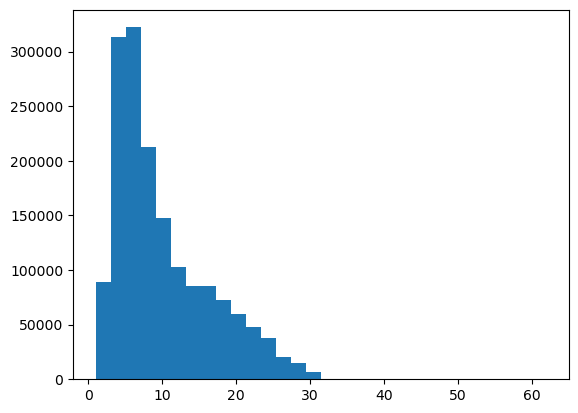

In [5]:
plt.hist([len(row['tgt'].split()) for i , row in df.iterrows()], bins=30)
plt.show()

In [6]:
len(df)

1619999

In [23]:
def text_preprocess(text):
    text = '[START] ' + text + ' [END]'
    return text
# src = df['src'].apply(lambda x: text_preprocess(x))
# tgt = df['tgt'].apply(lambda x: text_preprocess(x))

src = df['src'].tolist()
tgt = df['tgt'].tolist()

In [24]:
test_vec = df['src'][:5]

In [26]:
t = TextVectorization(standardize=text_preprocess, max_tokens=10)
t.adapt(test_vec)

In [28]:
t2 = t(df['src'][5:10])
t2

<tf.Tensor: shape=(5, 25), dtype=int64, numpy=
array([[2, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [2, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 3],
       [2, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0,
        0, 0, 0]])>

In [9]:
# vocab에 0번째에 START, -1 번째에 END 추가 

0                 [START] 그런데도 왜 아직도 수영모를 쓰고 계신지 궁금해요. [END]
1              [START] 이에 따라 이동제한 등 봉쇄조치는 이달 말까지 연장된다. [END]
2          [START] 이러한 교류와 접촉은 도시의 개방도와 국제화 정도를 높여준다는 점에서...
3          [START] 저희는 사고가 발생한 것을 증명하는 영상이나 파일을 보내드릴 수 있습...
4          [START] 이 세이버는 편의성과 스타일 및 혁신적 측면에서 궁극적인 시스템으로 ...
                                 ...                        
1619994                [START] 손끝에서 편안한 사용간을 주는 그립입니다. [END]
1619995    [START] 앞으로 무슨 일이 일어날지 안내받지 못했던 콕스는 공연 중 "일어나서...
1619996             [START] 응, 그리고 그들 인생의 남자에게는 더욱 그래. [END]
1619997    [START] 뛰어난 내구성을 가지고 안전 테스트를 거친 소재로 제작되어 비행 중에...
1619998    [START] 초기 개척이 완성되어 삶이 안정화된 후에는 새로 이주하는 조선인들의 ...
Name: tgt, Length: 1619999, dtype: object

### Model

In [87]:
def Vectorizing(inputs, outputs, vocab_size, max_length):
    data= inputs + outputs
    data = [i for d in data for i in d.split()]
    dataset = tf.data.Dataset.from_tensor_slices(data)

    text_vectorization = TextVectorization(
        max_tokens = vocab_size -1,
        output_mode = 'int',
        output_sequence_length = max_length + 1
    )
    text_vectorization.adapt(dataset)

    model = keras.models.Sequential()
    model.add(keras.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization)

    src_encode = model.predict(inputs)
    tgt_encode = model.predict(outputs)

    vocabulary = text_vectorization.get_vocabulary()
    vocabulary.insert(0, '[START]')
    vocabulary.insert(len(vocabulary), '[END]')

    vocab_dict = {}
    for i, k in enumerate(vocabulary):
        vocab_dict[k] = i
   
    return src_encode, tgt_encode, text_vectorization, vocab_dict
    


In [94]:
def create_train_dataset(inputs, outputs, batch_size = 64, buffer_size=1024):
    '''
    :param inputs: Source data :list
    :param outputs: Target data :list
    :param batch_size: batch_size
    :param buffer_size: 고정된 버퍼 크기로 데이터를 섞는데, 데이터가 완전히 랜덤적으로 뒤섞기 위해서는 입력된 데이터 크기보다 큰 수를 입력해 주셔야 한다.
    :return:
    '''
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': inputs,
            'decoder_inputs': outputs[:, :-1]
        },
        {
            'outputs': outputs[:, 1:]
        },
    ))

    dataset = dataset.cache() # cache를 활용해서 데이터를 로드할 때 빠른 처리를 기대해 봄
    dataset = dataset.shuffle(buffer_size) # buffer_size를 전체 데이터 수보다 크게하여 완전하게 섞음
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [95]:
i, o, t, v = Vectorizing(src[:10], tgt[:10], 2000, 70)
i


1/1 [==============================] - 0s 31ms/step


array([[ 60,  31,  97,  40,  38,  64,  61,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  5, 104,  26,   6,  49,  27,  57,  33,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [ 25,  62,  89,  58,  66, 111,  21, 103,  91,  78, 107,   7,  93,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0

In [96]:
a = create_train_dataset(i,o, 2, 11)
a

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 71), dtype=tf.int64, name=None), 'decoder_inputs': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)}, {'outputs': TensorSpec(shape=(None, 70), dtype=tf.int64, name=None)})>

In [65]:
def Embedding_layer(vocab_size, embed_dim, hidden_dim):
    inputs = keras.Input(shape=(None, embed_dim), name="inputs")
    token_emb = layers.Embedding(vocab_size, embed_dim)(inputs)
    maxlen = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = layers.Embedding(vocab_size, embed_dim)(positions)
    result = token_emb + positions
    return tf.keras.Model(inputs=inputs, outputs=result)

In [66]:
def Encoder(embed_dim, hidden_dim, num_heads, name='encoder_layer'):
    encoder_inputs = keras.Input(shape=(None, embed_dim), name="inputs")
    # 패딩마스크
    # padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(head_num=num_heads, activation='relu'
    , history_only=True,trainable=True)(encoder_inputs)
    attention = layers.Dropout(0.1)(attention)
    attention = layers.Normalization()(encoder_inputs + attention)

    outputs = layers.Dense(hidden_dim, activation='relu')(attention)
    outputs = layers.Dense(embed_dim)(outputs)

    outputs = layers.Dropout(0.1)(outputs)
    outputs = layers.Normalization()(attention + outputs)

    return keras.Model(
        inputs = encoder_inputs,
        outputs = outputs,
        name = name
    )

In [67]:
def Decoder(embed_dim, hidden_dim, num_heads, name='decoder_layer'):
    decoder_inputs = keras.Input(shape=(None, embed_dim), name="inputs")
    encoder_outputs = keras.Input(shape=(None, embed_dim), name="encoder_outputs")

    attention1 =  MultiHeadAttention(head_num=num_heads, activation='relu'
    , history_only=True,trainable=True)(decoder_inputs)
    attention1 = layers.Normalization()(decoder_inputs + attention1)

    attention2 = MultiHeadAttention(name='multyhead-attention', head_num=num_heads, activation='relu'
    , history_only=True,trainable=True)([decoder_inputs, encoder_outputs, encoder_outputs])

    attention2 = layers.Dropout(0.1)(attention2)
    attention2 = layers.Normalization()(attention1 + attention2)

    outputs = layers.Dense(hidden_dim, activation='relu')(attention2)
    outputs = layers.Dense(embed_dim)(outputs)

    outputs = layers.Dropout(0.1)(outputs)
    outputs = layers.Normalization()(attention2 + outputs)

    return keras.Model(
        inputs = [decoder_inputs, encoder_outputs],
        outputs = outputs,
        name=name
    )




In [72]:
def get_encoders(vocab_size, num_layers, embed_dim, hidden_dim, num_heads, dropout):
    inputs = keras.Input(shape=(None,), name="inputs")

    embedding = Embedding_layer(vocab_size, embed_dim, hidden_dim)(inputs)
    outputs = layers.Dropout(dropout)(embedding)

    for i in range(num_layers):
        outputs = Encoder(embed_dim, hidden_dim, num_heads, name = f'encoder_layer_{i+1}')(outputs)
    

    return keras.Model(
        inputs=inputs,
        outputs = outputs
    )


In [73]:
def get_decoders(vocab_size, num_layers, embed_dim, hidden_dim, num_heads, dropout):
    inputs = keras.Input(shape=(None,), name="inputs")
    encoder_outputs = keras.Input(shape=(None, embed_dim), name="encoder_outputs")

    embedding = Embedding_layer(vocab_size, embed_dim, hidden_dim)(inputs)
    outputs = layers.Dropout(dropout)(embedding)

    for i in range(num_layers):
        outputs = Decoder(embed_dim, hidden_dim, num_heads, name=f'decoder_layer_{i+1}')([outputs, encoder_outputs])
    
    return keras.Model(
        inputs=[inputs, encoder_outputs],
        outputs = outputs
    )

In [102]:
def get_transformer(vocab_size, embed_dim, hidden_dim, encoder_num, decoder_num, num_heads, dropout, name='transformer'):
    inputs = keras.Input(shape=(None,), name="inputs")
    decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")

    encoder_outputs = get_encoders(vocab_size,encoder_num, embed_dim, hidden_dim, num_heads, dropout)(inputs)

    decoder_outputs = get_decoders(vocab_size, decoder_num, embed_dim, hidden_dim, num_heads, dropout)([decoder_inputs, encoder_outputs])

    outputs = layers.Dense(vocab_size, name='outputs')(decoder_outputs)

    return keras.Model(inputs = [inputs, decoder_inputs], outputs=outputs, name=name)

In [103]:
test_model = get_transformer(vocab_size=8000,
embed_dim=128,
hidden_dim=256,
encoder_num=4,
decoder_num=4,
num_heads=4,
dropout=0.1)

In [105]:
test_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',)

In [106]:
test_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 model_9 (Functional)           (None, None, 128)    2577928     ['inputs[0][0]']                 
                                                                                                  
 model_11 (Functional)          (None, None, 128)    2843148     ['decoder_inputs[0][0]',         
                                                                  'model_9[0][0]']      

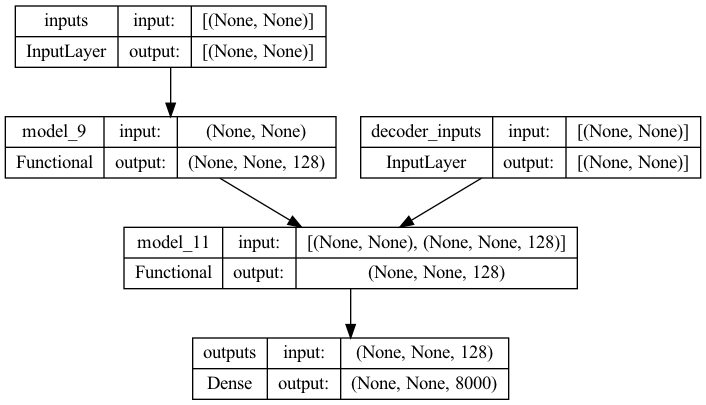

In [107]:
keras.utils.plot_model(test_model, show_shapes=True)

In [108]:
test_model.fit(a, epochs=1)

5/5 [==============================] - 13s 103ms/step - loss: 9.6835


#### Predict 구현